Purpose: compare predictors of the Probit and Logit models from Python statsmodels.formula.api package
- Full list of models avaliable: https://www.statsmodels.org/stable/api.html#statsmodels-formula-api

Dataset - Spambase: compare predictors of Logiv vs Probit
    #> Binary target: Spam vs. not spam
    #> Why useful: Text‑derived numeric predictors; good for seeing how logit vs. probit behave with many predictors & correlated features.
    #> Expectation: the curves for the two models will almost overlap. The difference will be the scaling on the coefficient.

*Logit Model - Summarised:*

>Logit assumes a logistic distribution (fatter tails, slightly flatter peak): 
- mean = 0 and Variance ≈ π²/3 = 3.29
- Logit predicted probabilities spread slightly more into 0 and 1 because of heavier tails
> Compared to Probit:
- Logit is simplier and easier to interpret (odds ratios)
- Industry standard
-  Logit coefficients tend to be about 1.6× (≈ π/√3) larger than probit coefficients, as distribution have fatter tail ends

*Probit Model - Summarised:*

>Probit assumes a standard normal distribution (thinner tails, sharper peak): 
- Mean = 0 and Varaince = 1
- Probit predicted probabilities tend to cluster more tightly around 0.5

>For many behavioural, psychometric, and economic processes, it’s often more natural to assume the underlying propensity follows a normal distribution—making a probit specification conceptually cleaner.
- reduces sensitivity to extreme values = Slightly more conservative estimates at extremes
- Causal inference = probit is a typical model for propensity scores as model often aligns with normal distributional assumptions when estimating treatment assignment probabilities

In [28]:
# Set up: import packages
import pandas as pd
import statsmodels.formula.api as sm
import pandas as pd

#!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Set up dummy data: Spambase
url = "https://raw.githubusercontent.com/readytensor/rt-datasets-binary-classification/main/datasets/processed/spambase/spambase.csv"
    #> from git Hub repository of datasets

df_Spam = pd.read_csv(url)



Matplotlib is building the font cache; this may take a moment.


In [17]:
#Familiarise with Descriptive stats: File shape, column names, dtypes, suspected mis‑types (IDs as numeric, categories as free text), duplicated rows/IDs.

#df_Spam.shape, df_Spam.columns.tolist()
#df_Spam.info()
#df_Spam.head()
df_Spam.describe()
    #> Class = y - only Binary Variable
    #> All other variables as explanitory
    #> Ranges suggest standardisng numeric predictors ((x - mean)/std) to not dominate the model coefficients.

#dupe_rows = df_Spam.duplicated().sum()
#dupe_keys = df_Spam.duplicated(subset=["id"]).sum() if "id" in df_Spam.columns else None
#dupe_rows, dupe_keys


,id,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,2300.000000,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,1328.338624,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,1150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,2300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,3450.000000,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4600.000000,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [22]:
# Validate Probit / Logit requirements
# Step 1: Examine y = class

# Examine target variable
y = df_Spam['class']
    #> Binary confirmed -- counts: 0 = 2788 and 1 = 1813

# Check unique values
#df_Spam['class'].value_counts()

# Check proportions
df_Spam['class'].value_counts(normalize=True)
    #> Proportions -- some imbalance: 0 = 60.6% and 1 = 39.4%
    #> Logistic regression can handle up to ~70/30 imbalance without special adjustments
    #> Model implications: predicted probabilities will naturally reflect that class 0 is slightly more frequent

class
0    0.605955
1    0.394045
Name: proportion, dtype: float64

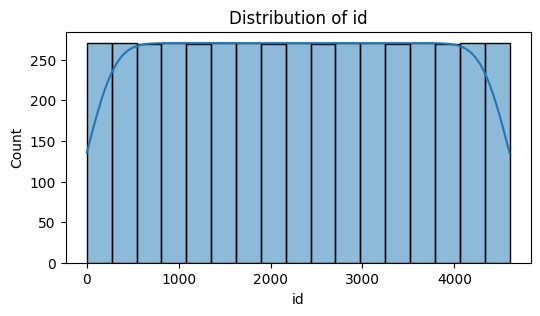

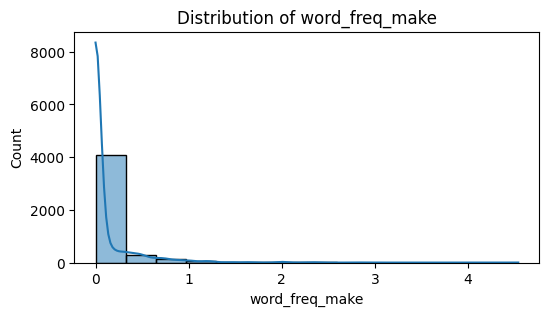

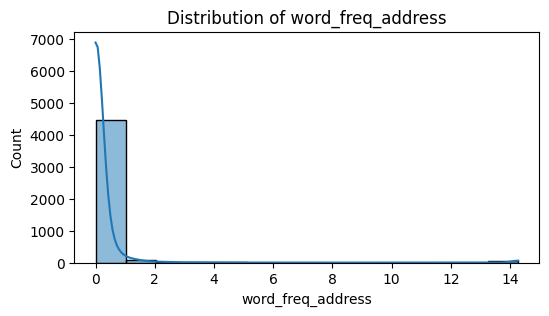

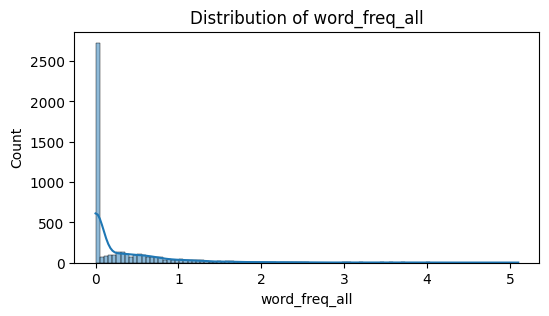

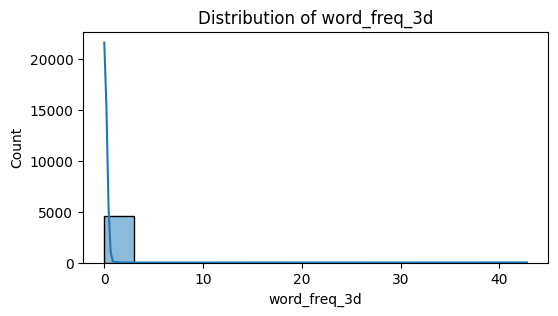

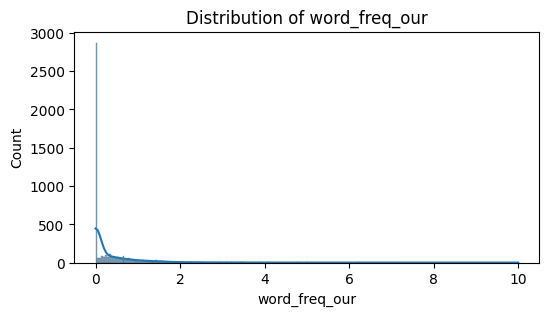

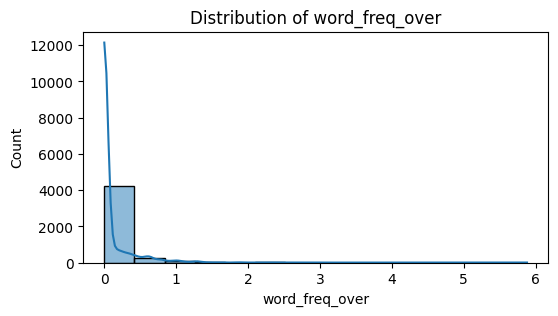

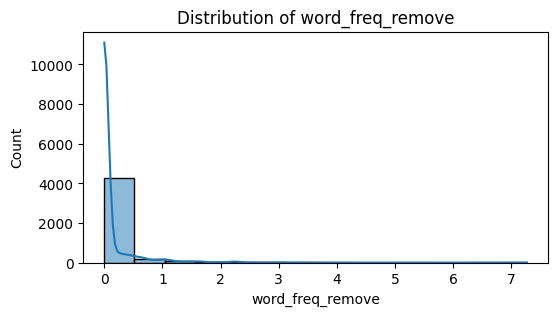

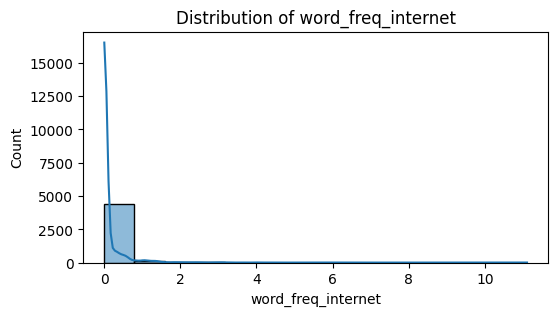

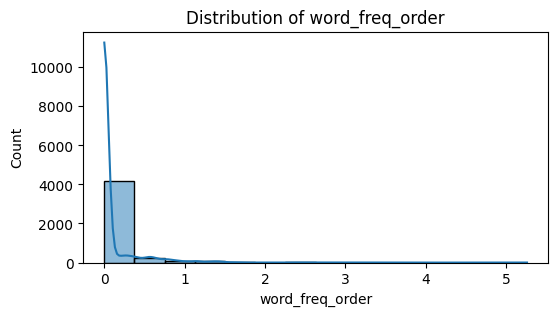

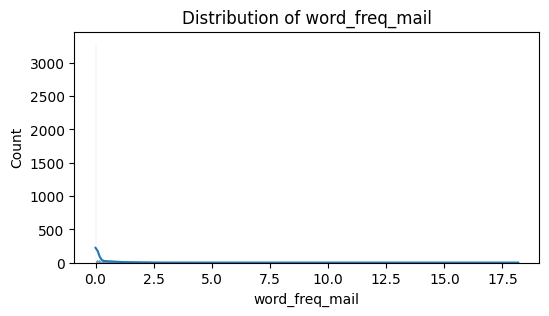

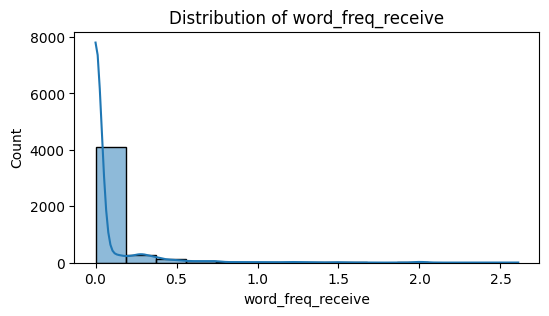

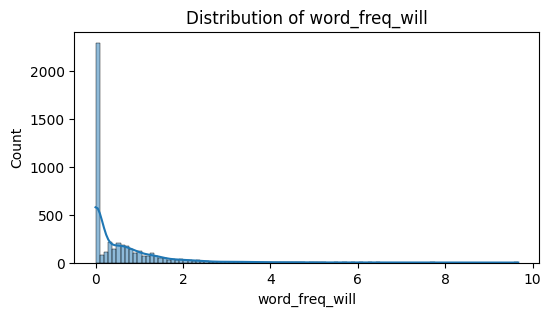

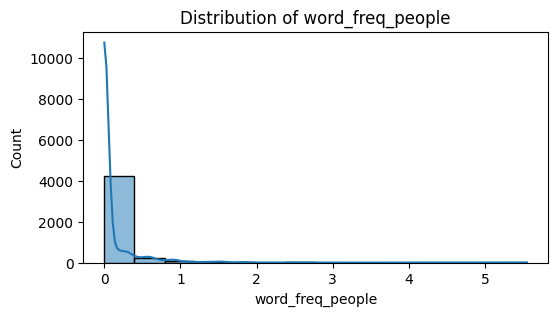

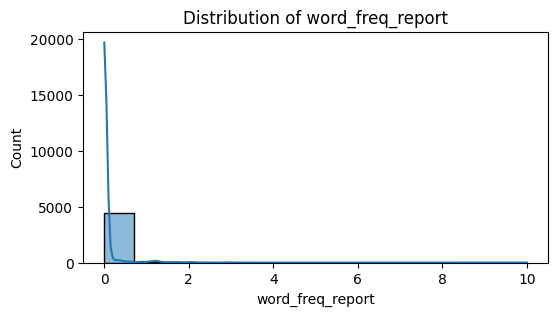

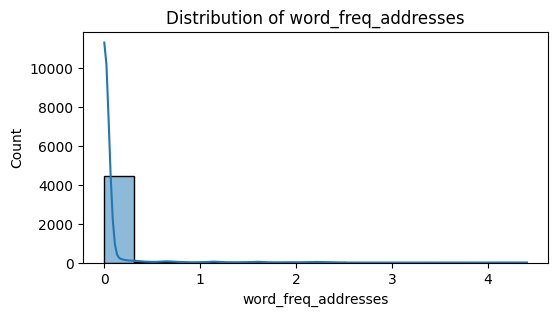

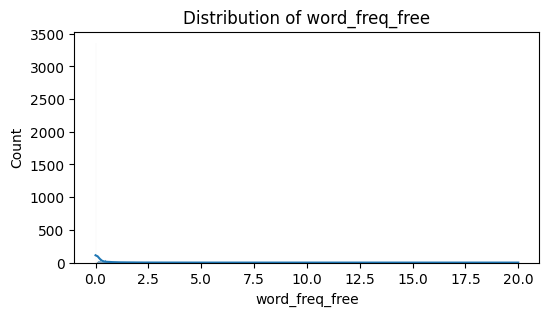

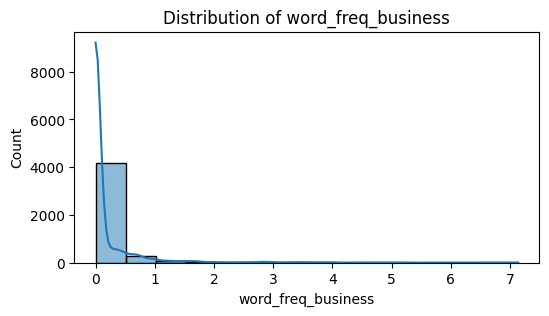

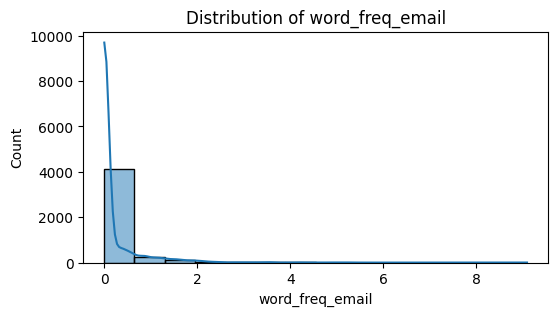

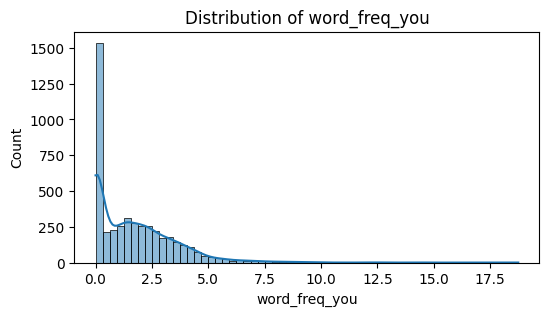

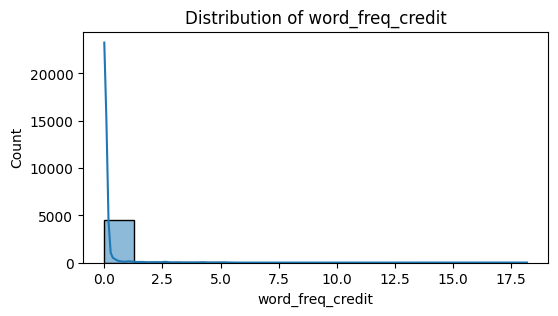

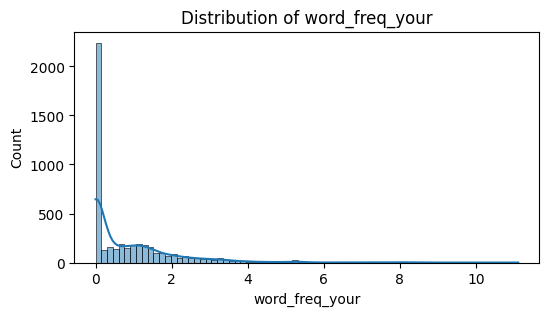

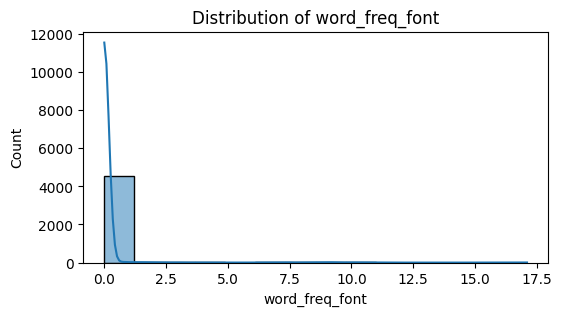

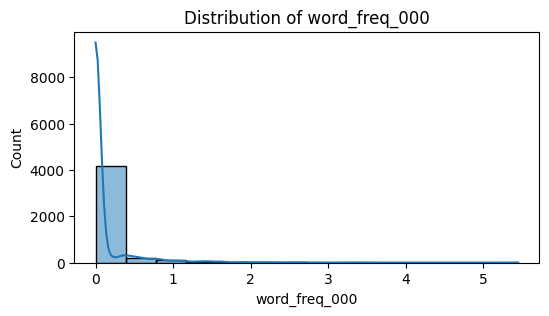

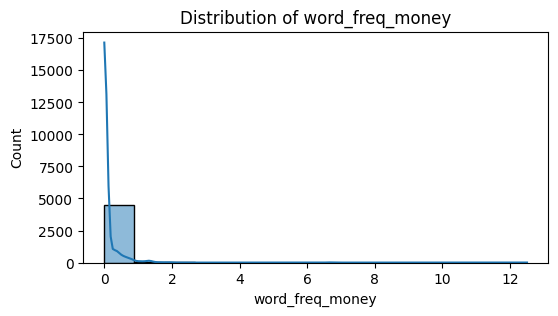

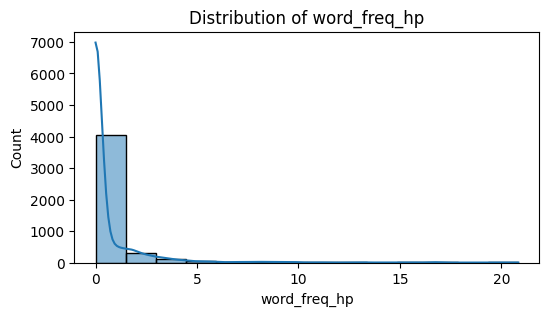

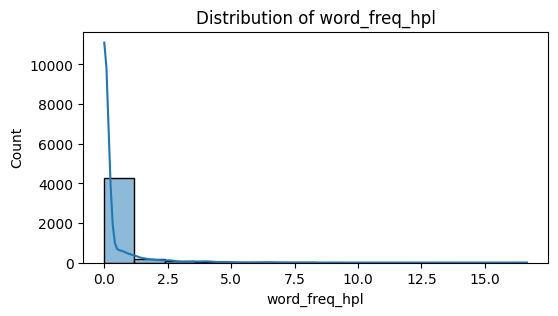

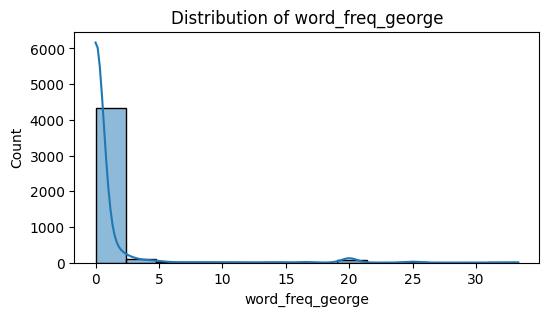

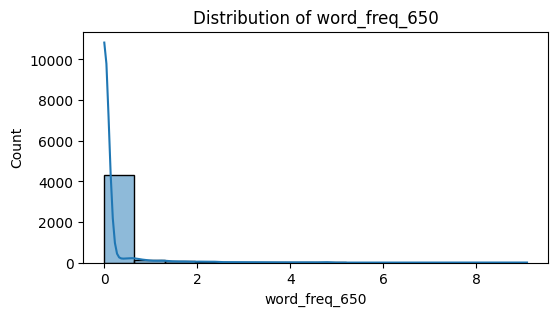

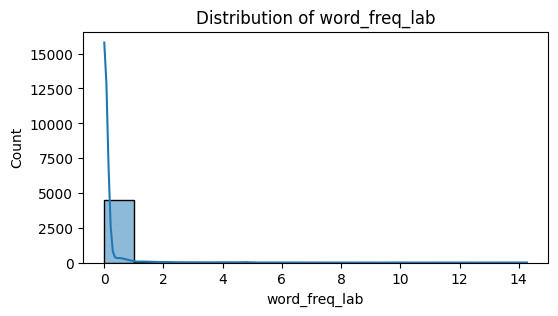

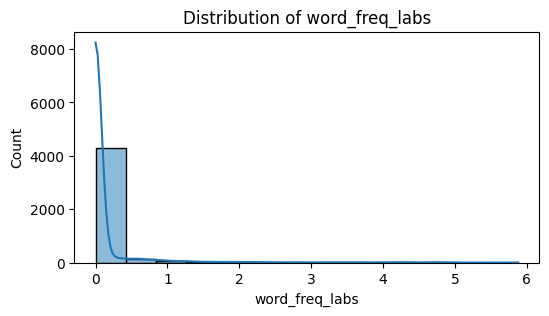

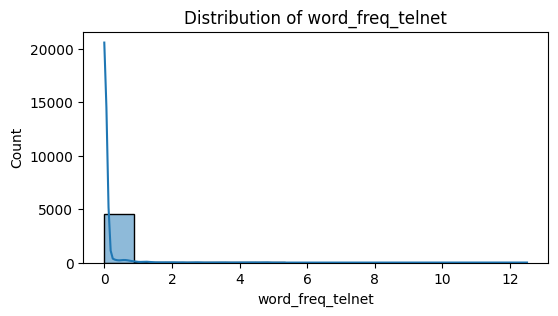

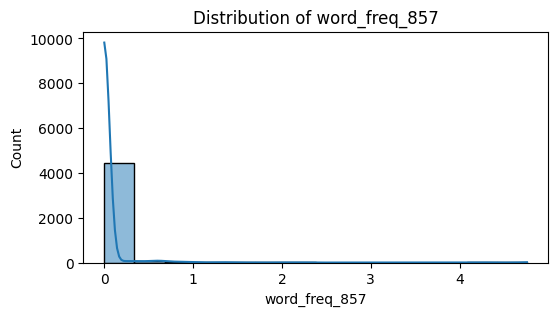

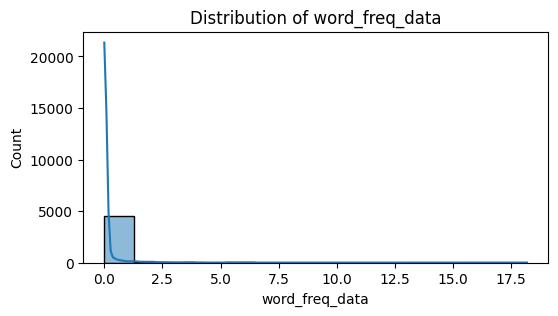

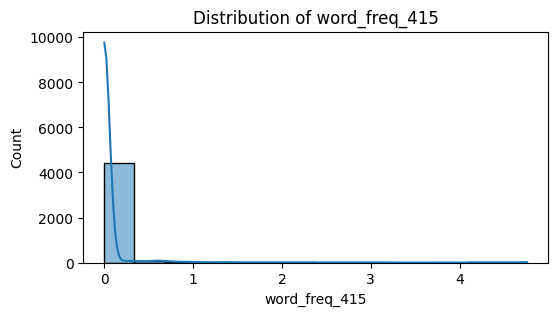

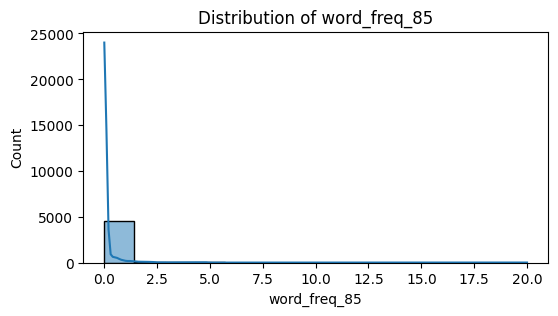

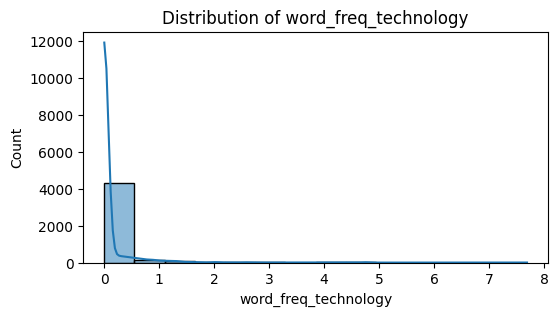

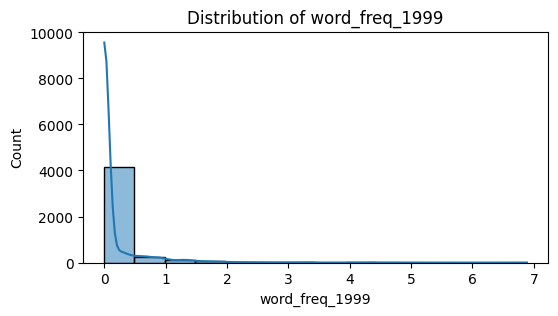

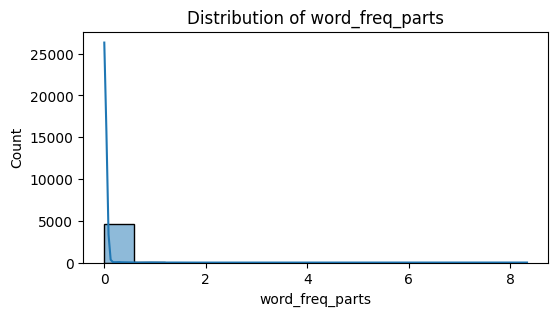

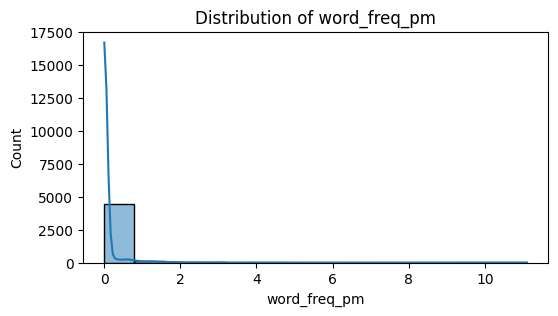

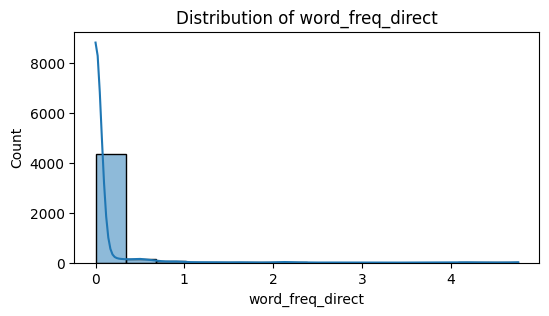

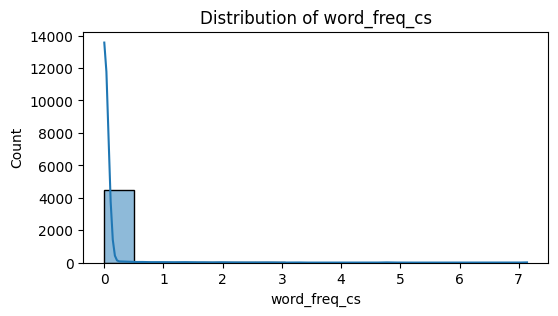

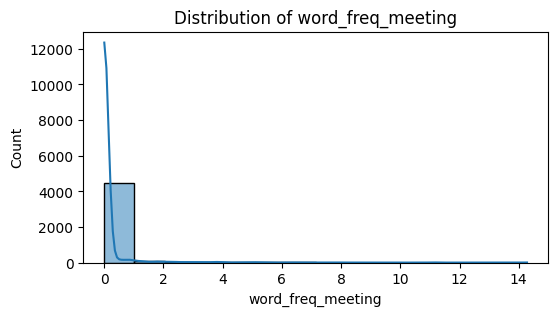

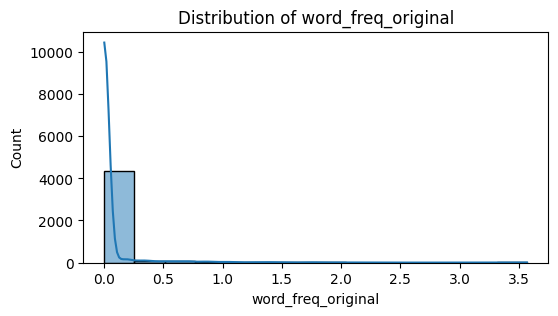

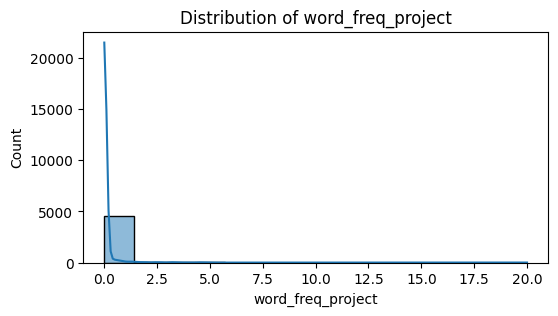

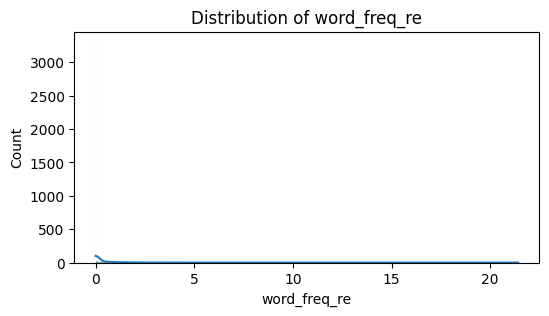

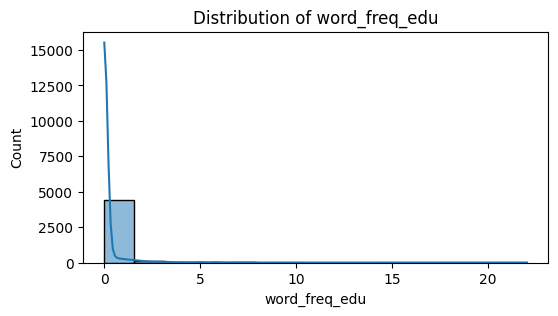

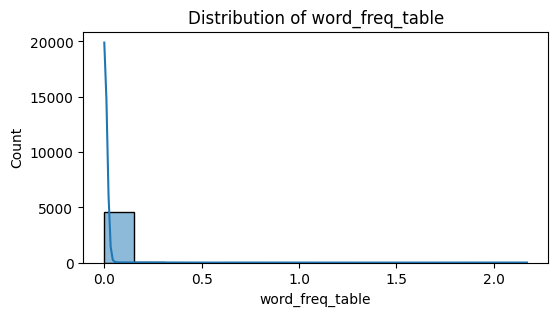

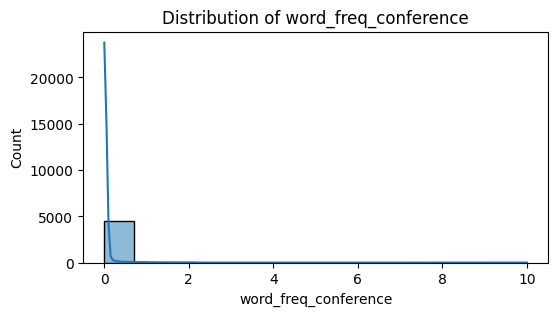

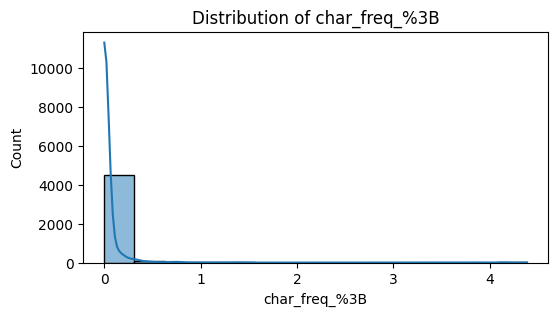

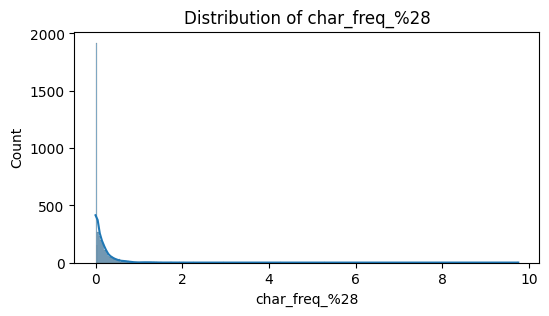

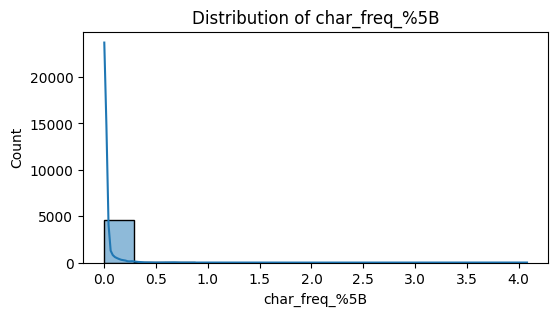

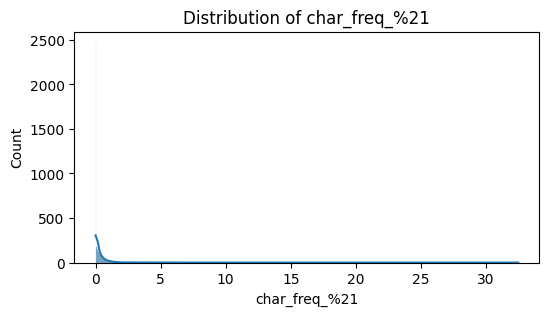

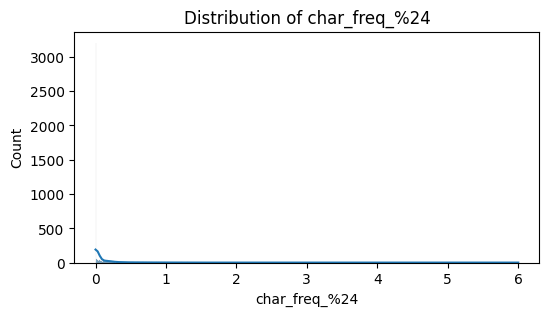

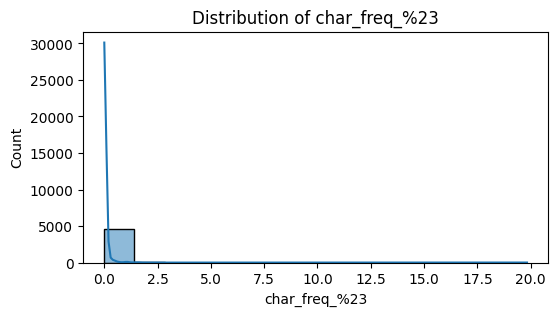

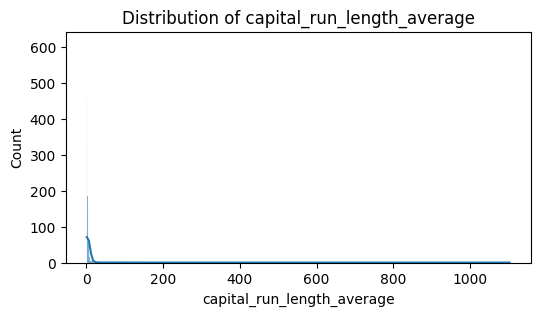

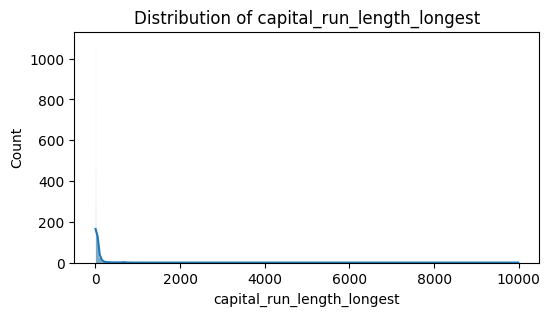

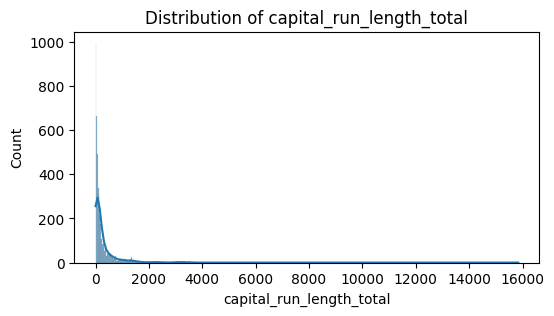

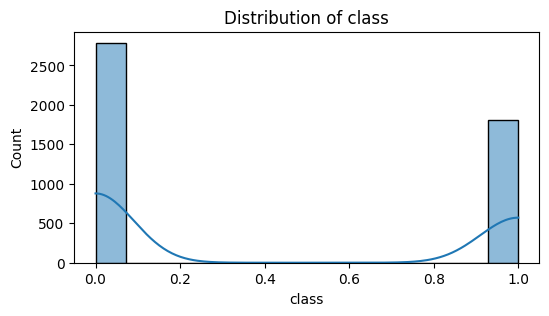

In [31]:
# Step 2: Explore feature distributions & scales
numeric_cols = df_Spam.select_dtypes(include='number').columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_Spam[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

    #> check: Trnsformation required.
    #> Most variables have right skewed distributions (small numbers) and zeros. 
        #>> Most emails will have 0 occurrences of a given spam word → explains the zeros.
        #>> Right-skewed predictors can affect the linear-in-logit assumption.
        #>> Transformation: consider log(x + 1) or sqrt(x) to normlaise the distribution.